In [2]:
import os, glob
import cv2, numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import skimage
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import svm
from scipy.ndimage.measurements import label
import sklearn

In [3]:
DATA_FOLDER = '/home/carnd/data_drive/data/images6/'
training_imgs = glob.glob(DATA_FOLDER + '*.png')
print ('Number of images:', len(training_imgs))

Number of images: 108994


In [5]:
# Data generators
non_car_imgs = [t for t in training_imgs if 'non_car' in t]
car_imgs = [t for t in training_imgs if 'non_car' not in t]
print('Number of car images:', len(car_imgs))
print('Number of noncar images:', len(non_car_imgs))
min_img_count = min([len(car_imgs), len(non_car_imgs), 150000])
print('Number of min image count:', min_img_count)

#Random shuffle data and create train/test split of 0.4
np.random.shuffle(car_imgs)
np.random.shuffle(non_car_imgs)
training_imgs_subset = car_imgs[:min_img_count] + non_car_imgs[:min_img_count]

# 40 percent data as validation set
train_samples, validation_samples = train_test_split(training_imgs_subset, test_size=0.4)

# Generator - only uses one channel of intensity image
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            values = []
            for batch_sample in batch_samples:
                image = cv2.imread(batch_sample)[:, :, 0:1]
                if 'non_car' in batch_sample:
                    values.append(0)
                else:
                    values.append(1)
                images.append(image)
            yield (np.array(images), np.array(values))

batch_size = 1000
nb_train_samples = len(train_samples)
nb_validation_samples = len(validation_samples)
print('Number of training samples:', nb_train_samples)
print('Number of validation samples:', nb_validation_samples)
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

Number of car images: 17692
Number of noncar images: 91302
Number of min image count: 17692
Number of training samples: 21230
Number of validation samples: 14154


In [6]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Convolution2D, Dropout, Activation
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D
from keras import optimizers
import keras

#Simple model - used to train
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(50, 75, 1)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
print (model.summary()) 

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 50, 75, 1)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 3750)          0           lambda_1[0][0]                   
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 256)           960256      flatten_1[0][0]                  
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 256)           0           dense_1[0][0]                    
___________________________________________________________________________________________

In [7]:
from keras.models import Model
import matplotlib.pyplot as plt

# Save the model if validation loss improves from the last best model
modelCheckpoint = keras.callbacks.ModelCheckpoint('best_model.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose=1)
# Save the training log
csv_logger = keras.callbacks.CSVLogger('training.log')
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])

history_object = model.fit_generator(train_generator,
                                     samples_per_epoch = len(train_samples),
                                     nb_epoch=3,
                                     nb_val_samples = len(validation_samples),
                                     validation_data = validation_generator,
                                     verbose=1,
                                     callbacks=[modelCheckpoint, csv_logger])

Epoch 1/3
21230/21230 [==============================] - 8s - loss: 0.4217 - acc: 0.8182 - val_loss: 0.2455 - val_acc: 0.9056
Epoch 2/3
21230/21230 [==============================] - 3s - loss: 0.2015 - acc: 0.9335 - val_loss: 0.1421 - val_acc: 0.9532
Epoch 3/3
21230/21230 [==============================] - 3s - loss: 0.1289 - acc: 0.9668 - val_loss: 0.1001 - val_acc: 0.9783


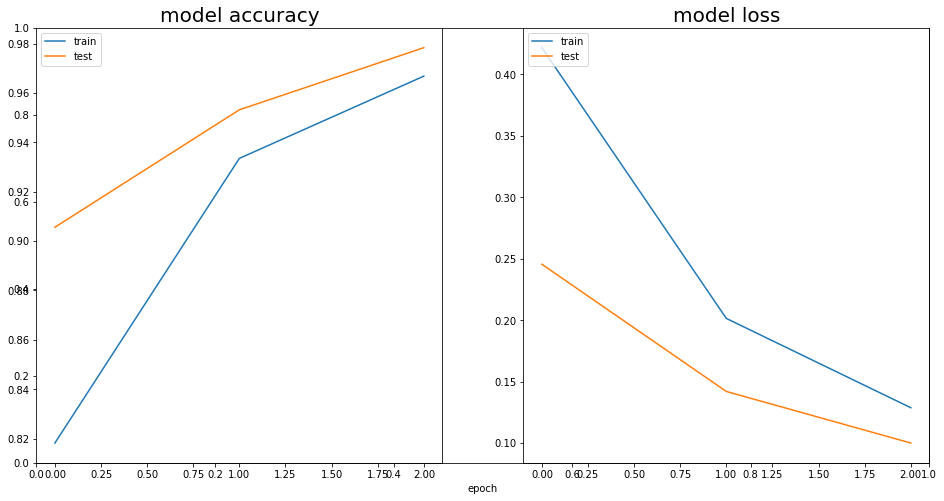

In [8]:
plt.clf()
f = plt.figure(figsize=(16, 8))
#plt.ylabel('accuracy')
plt.xlabel('epoch')

# summarize history for accuracy
ax1 = f.add_subplot(1, 2, 1)
ax1.plot(history_object.history['acc'])
ax1.plot(history_object.history['val_acc'])
ax1.set_title('model accuracy', fontsize=20)
ax1.legend(['train', 'test'], loc='upper left')

#summarize history for loss
ax2 = f.add_subplot(1, 2, 2)
ax2.plot(history_object.history['loss'])
ax2.plot(history_object.history['val_loss'])
ax2.set_title('model loss', fontsize=20)
ax2.legend(['train', 'test'], loc='upper left')

plt.show()
plt.savefig('model_loss.png')

# Predicting using the model

In [9]:
from keras.models import load_model
final_model = load_model('best_model.h5')

In [25]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(75, 50), xy_overlap=(0.75, 0.75)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            #if (endx - startx) == (xy_window[0]) and (endy - starty) == (xy_window[1]):
            if(endx < img.shape[1] and endy < img.shape[0]):
                window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, final_model, threshold=0.75):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = img[window[0][1]:window[1][1], window[0][0]:window[1][0], 0:1]
        #4) Predict using your classifier
        #prediction = final_model.predict(np.array([single_win_features]))
        prediction = final_model.predict(np.array([test_img]))
        #5) If positive (prediction == 1) then save the window
        if prediction > threshold:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes_and_return_centroid(img, labels):
    bboxes = []
    bbox_centers = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], 255, 6)
        bboxes.append(bbox)
        bbox_center = [bbox[0][0] + bbox[1][0], bbox[0][1] + bbox[1][1]]
        bbox_centers.append(bbox_center)
    # Return the image
    return img, np.array(np.array(bbox_centers) * 0.5, dtype=np.int32)

def ignore_small_boxes_and_return_centroid(img, labels):
    bboxes = []
    bbox_centers = []
    box_data = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        if (abs(bbox[1][0] - bbox[0][0]) < 15.0) or (abs(bbox[1][1] - bbox[0][1]) < 15.0):
            continue
        else:
            box_data.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], 255, 6)
        bboxes.append(bbox)
        bbox_center = [bbox[0][0] + bbox[1][0], bbox[0][1] + bbox[1][1]]
        bbox_centers.append(bbox_center)
    # Return the image
    return img, np.array(np.array(bbox_centers) * 0.5, dtype=np.int32), box_data


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [11]:
TEST_IMGS_INFO = '/home/carnd/data_drive/data/round_1_test/19_f2/unlabelled/'
#TEST_IMGS_INFO = '/home/carnd/data_drive/data/didi_final_data/data_3/14/unlabelled/'
#test_imgs = glob.glob(TEST_IMGS_INFO + '*intensity*.png')
test_imgs = sorted(glob.glob(TEST_IMGS_INFO + '*_rot0.0_intensity*.png'))
print ('Number of images:', len(test_imgs))

Number of images: 268


In [12]:
single_channel_im1 = cv2.imread(test_imgs[0])
single_channel_im2 = cv2.imread(test_imgs[0].replace('intensity', 'distance'))[:, :, 0]
single_channel_im1[:, :, 1] = single_channel_im2
single_channel_im = single_channel_im1

windows = slide_window(single_channel_im)
print('All windows used in sliding search:', windows)

All windows used in sliding search: [((0, 0), (75, 50)), ((18, 0), (93, 50)), ((36, 0), (111, 50)), ((54, 0), (129, 50)), ((72, 0), (147, 50)), ((90, 0), (165, 50)), ((108, 0), (183, 50)), ((126, 0), (201, 50)), ((144, 0), (219, 50)), ((162, 0), (237, 50)), ((180, 0), (255, 50)), ((198, 0), (273, 50)), ((216, 0), (291, 50)), ((234, 0), (309, 50)), ((252, 0), (327, 50)), ((270, 0), (345, 50)), ((288, 0), (363, 50)), ((306, 0), (381, 50)), ((324, 0), (399, 50)), ((342, 0), (417, 50)), ((360, 0), (435, 50)), ((378, 0), (453, 50)), ((396, 0), (471, 50)), ((414, 0), (489, 50)), ((432, 0), (507, 50)), ((450, 0), (525, 50)), ((468, 0), (543, 50)), ((486, 0), (561, 50)), ((504, 0), (579, 50)), ((522, 0), (597, 50)), ((0, 12), (75, 62)), ((18, 12), (93, 62)), ((36, 12), (111, 62)), ((54, 12), (129, 62)), ((72, 12), (147, 62)), ((90, 12), (165, 62)), ((108, 12), (183, 62)), ((126, 12), (201, 62)), ((144, 12), (219, 62)), ((162, 12), (237, 62)), ((180, 12), (255, 62)), ((198, 12), (273, 62)), ((2

In [13]:
#Image has to be normalized between 0 to 255
def get_windows_detected(image, windows):
    hot_windows = search_windows(image, windows, final_model, 0.5)                       

    draw_image = np.copy(image)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    
    # Add heat to each box in box list
    heat = np.zeros_like(image).astype(np.float)
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 4)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img, centers = draw_labeled_bboxes_and_return_centroid(np.copy(image), labels)
    
    return window_img, draw_img, heatmap, centers

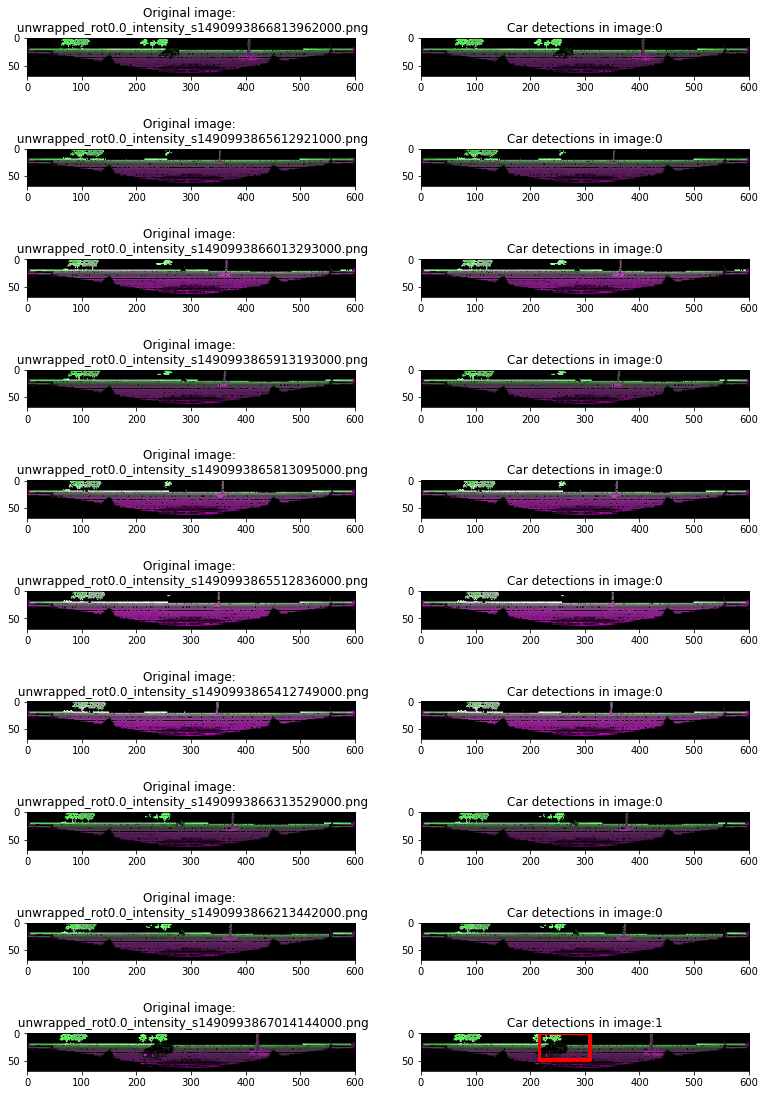

Processing took: 0.0840919812520345 minutes


In [34]:
plt.clf()
fig = plt.figure(figsize=(20, 20))
col_size = 3
start_time = time.time()
number_of_images_to_show = 10
indices_to_display = sklearn.utils.resample(range(len(test_imgs)), n_samples=number_of_images_to_show, replace=False)
#indices_to_display = sklearn.utils.resample(range(20), n_samples=number_of_images_to_show, replace=False)
center_data = {}
heatmaps = []

#for idx_tmp, test_img in enumerate(test_imgs[220:240]):
for idx_tmp, test_img in enumerate(test_imgs):
    single_channel_im1 = cv2.imread(test_img)
    single_channel_im2 = cv2.imread(test_img.replace('intensity', 'distance'))[:, :, 0]
    single_channel_im1[:, :, 1] = single_channel_im2
    single_channel_im = single_channel_im1

    window_img, draw_img, heatmap, centers = get_windows_detected(single_channel_im, windows)
    heatmaps.append(heatmap)

    #Use cumulative heatmap - and test for last 5 frames to remove false positives
    cum_heat_map = np.sum(heatmaps[max([0, (idx_tmp - 5)]) : (idx_tmp + 1)], axis=0)
    # Apply threshold to help remove false positives
    new_heatmap = apply_threshold(cum_heat_map, 4)
    # Visualize the heatmap when displaying    
    new_heatmap = np.clip(new_heatmap, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(new_heatmap)
    draw_img, centers, box_data = ignore_small_boxes_and_return_centroid(np.copy(single_channel_im), labels)

    center_data[os.path.basename(test_img)] = \
    [[t[0], t[1], (float(single_channel_im1[int(t[1]), int(t[0]), 1]) / 255.0) * 40.0] for t in centers.tolist()]
    
    if idx_tmp % 500 == 0 and idx_tmp > 0:
        print ('Processing:', idx_tmp, centers.tolist())
    
    if idx_tmp in indices_to_display:
        idx = indices_to_display.index(idx_tmp)
        idx1 = idx * col_size + 1

        ax1 = fig.add_subplot(number_of_images_to_show, col_size, idx1)
        ax1.set_title('Original image: \n ' + os.path.basename(test_img))
        ax1.imshow(single_channel_im, cmap='gray')

        ax2 = fig.add_subplot(number_of_images_to_show, col_size, idx1 + 1)
        ax2.set_title('Car detections in image:' + str(len(centers)))
        ax2.imshow(draw_img, cmap='hot')
    
plt.show()
fig.tight_layout()
end_time = time.time()
print('Processing took:', (end_time - start_time) / 60.0, 'minutes')

In [32]:
import json
with open('center.json', 'w') as fp:
    json.dump(center_data, fp)

In [33]:
print(json.dumps(center_data))

{"unwrapped_rot0.0_intensity_s1490993869115943000.png": [[253, 24, 16.470588235294116]], "unwrapped_rot0.0_intensity_s1490993864211696000.png": [], "unwrapped_rot0.0_intensity_s1490993864812244000.png": [], "unwrapped_rot0.0_intensity_s1490993867314393000.png": [[244, 30, 10.352941176470589]], "unwrapped_rot0.0_intensity_s1490993858907103000.png": [], "unwrapped_rot0.0_intensity_s1490993847997707000.png": [], "unwrapped_rot0.0_intensity_s1490993857605975000.png": [], "unwrapped_rot0.0_intensity_s1490993848898473000.png": [], "unwrapped_rot0.0_intensity_s1490993866713901000.png": [], "unwrapped_rot0.0_intensity_s1490993862810505000.png": [], "unwrapped_rot0.0_intensity_s1490993857906233000.png": [], "unwrapped_rot0.0_intensity_s1490993868815712000.png": [[253, 24, 15.529411764705882]], "unwrapped_rot0.0_intensity_s1490993851800946000.png": [], "unwrapped_rot0.0_intensity_s1490993865012389000.png": [], "unwrapped_rot0.0_intensity_s1490993844794879000.png": [], "unwrapped_rot0.0_intensity